# 0. Import Libraries

In [2]:
from __future__ import print_function, division

import os
import time
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.folder import make_dataset
import torchvision.transforms.functional as F
import torch.nn.functional as torch_f
from torchvision import models

from transformers import ViTModel,ViTForImageClassification, ViTConfig


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from torchsummary import summary
from torchinfo import summary as torchinfo_summary

from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

%matplotlib inline
plt.ion()   # interactive mode

Set the seed

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Load status

In [4]:
load_checkpoint = False
loaded = False

Specify device

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print ('device:', device)

device: cuda:2


# 1. Data Pre-Processing

### 1.1 Define Datasets

5 class dataset class (sg_food_dataset)

In [6]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

Binary classification dataset (binary_dataset)

In [7]:
class binary_dataset(torch.utils.data.Dataset):
    def __init__(self, root, class_id, transform=None, include_others=True):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {root}.")

        self.classes = [all_classes[x] for x in class_id] + (['Others'] if include_others else [])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        others_index = self.class_to_idx.get('Others', len(self.classes))  # 默认为最后一个索引
        
        self.samples = []
        for entry in os.scandir(root):
            if entry.is_dir():
                dir_index = self.class_to_idx.get(entry.name, others_index)
                for img_entry in os.scandir(entry.path):
                    if img_entry.name.endswith(('jpg', 'jpeg', 'png')) and (dir_index != others_index or include_others):
                        self.samples.append((img_entry.path, dir_index))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

### 1.2 Data Augmentation and Normalization

In [8]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1 , saturation = 0.1), #random brightness, contrast etc
        transforms.GaussianBlur(kernel_size=(15, 15)),
        transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3), #random brightness, contrast etc
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'test': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize((256,256), antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

In [9]:
data_dir = './sg_food' # You should change this to the directory where you store the dataset.
subfolder = {'train': 'train', 'val': 'val', 'test': 'test'}
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
batch_size = 64

### 1.3 Create Dataloader

5 class dataset (dataloaders)

In [10]:
# Define the dataset
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True if x == 'train' else False, num_workers=0)
              for x in ['train', 'val', 'test']}

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


binary classification dataset (binaryloaders)

In [11]:
# Define the dataset with the others category included
binary_image_datasets = {
    x: binary_dataset(
        root=os.path.join(data_dir, subfolder[x]),
        class_id=selected_classes,
        transform=data_transforms[x],
        include_others=True  # 只在训练集中包括 'others' 类别
    ) for x in ['train', 'val', 'test']
}
class_names = binary_image_datasets['train'].classes
print('Selected classes with "others":', class_names)

binaryloaders = {
    x: torch.utils.data.DataLoader(binary_image_datasets[x], batch_size=64, shuffle=True if x == 'train' else False, num_workers=0)
    for x in ['train', 'val', 'test']
}

Selected classes with "others": ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata', 'Others']


## 1.3. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 

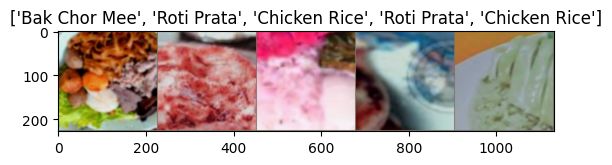

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes[:5]])

# 2. Model Initailization

### 2.1 Define Models

In [13]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights

### 2.2 Modify Models
Change the last layer for 5 class classification

In [14]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify VGG19
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Resnet50
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

Summary

In [15]:
# VGG16
summary(vgg16.to("cuda"), input_size=(3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
# VGG19
summary(vgg19.to('cuda'), input_size=(3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [17]:
# ResNet18
summary(resnet18.to("cuda"), input_size=(3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
#Resnet 50
summary(resnet50.to("cuda"), input_size=(3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
# Inception_v3
summary(inception_v3.to("cuda"), input_size=(3, 299, 299), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### 2.3 Dict for Models

In [20]:
models_dict = {
    "VGG16": vgg16,
    "VGG19": vgg19,
    "ResNet18": resnet18,
    "ResNet50": resnet50,
    "Inception_v3": inception_v3
}

### 2.4 Training

Define train function

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if is_inception and phase == 'train':
                    inputs = torch.stack([F.resize(input, size=(299, 299)) for input in inputs])

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history,train_acc_history, train_loss_history


Define train visualize function

In [22]:
def visualize_training(model_name, val_acc_history, val_loss_history, train_acc_history, train_loss_history):
    plt.figure()
    # 确保将 tensor 转移到 CPU
    val_acc_history_cpu = [h.cpu() for h in val_acc_history]
    train_acc_history_cpu = [h.cpu() for h in train_acc_history]
    plt.plot(val_acc_history_cpu, 'r--', label='Validation Accuracy')
    plt.plot(train_acc_history_cpu, 'b-', label='Training Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    val_loss_history_cpu = [h.cpu() for h in val_loss_history]
    train_loss_history_cpu = [h.cpu() for h in train_loss_history]
    plt.plot(val_loss_history_cpu, 'r--', label='Validation Loss')
    plt.plot(train_loss_history_cpu, 'b-', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()
    plt.show()

Start training

Training VGG16...
Epoch 1/150
----------
train Loss: 1.6470 Acc: 0.2020
val Loss: 1.5407 Acc: 0.2933

Epoch 2/150
----------
train Loss: 1.5608 Acc: 0.2820
val Loss: 1.4833 Acc: 0.4733

Epoch 3/150
----------
train Loss: 1.4860 Acc: 0.3800
val Loss: 1.4150 Acc: 0.5200

Epoch 4/150
----------
train Loss: 1.4478 Acc: 0.3800
val Loss: 1.3235 Acc: 0.5667

Epoch 5/150
----------
train Loss: 1.4007 Acc: 0.4320
val Loss: 1.2062 Acc: 0.5667

Epoch 6/150
----------
train Loss: 1.3333 Acc: 0.4460
val Loss: 1.0736 Acc: 0.6000

Epoch 7/150
----------
train Loss: 1.2098 Acc: 0.5220
val Loss: 0.9274 Acc: 0.6933

Epoch 8/150
----------
train Loss: 1.1602 Acc: 0.5440
val Loss: 0.8047 Acc: 0.6867

Epoch 9/150
----------
train Loss: 1.0975 Acc: 0.5620
val Loss: 0.7031 Acc: 0.7267

Epoch 10/150
----------
train Loss: 1.0743 Acc: 0.5640
val Loss: 0.6625 Acc: 0.7333

Epoch 11/150
----------
train Loss: 0.9855 Acc: 0.6120
val Loss: 0.6313 Acc: 0.7533

Epoch 12/150
----------
train Loss: 0.9548 Acc: 0.6140
v

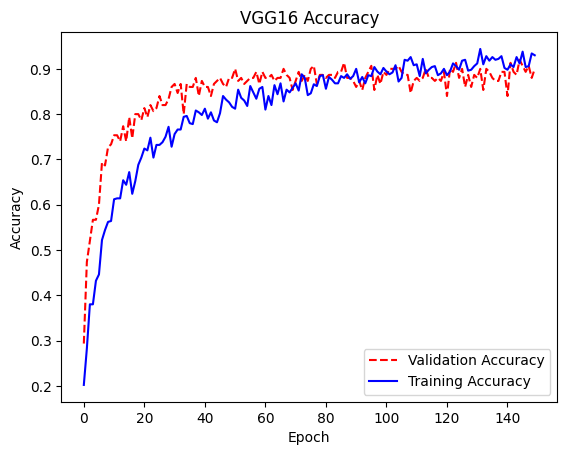

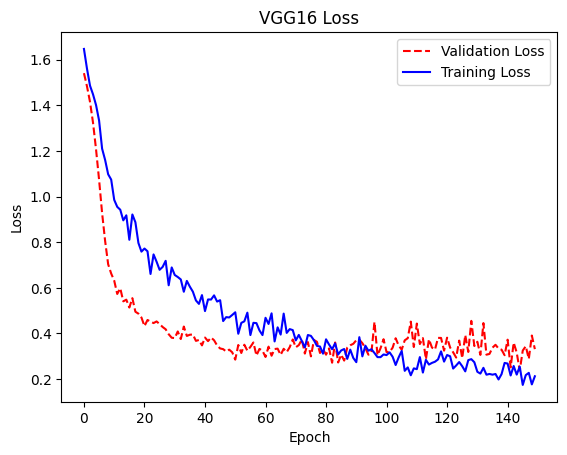

Training VGG19...
Epoch 1/150
----------
train Loss: 1.5799 Acc: 0.2560
val Loss: 1.4847 Acc: 0.3933

Epoch 2/150
----------
train Loss: 1.5518 Acc: 0.2940
val Loss: 1.4167 Acc: 0.4867

Epoch 3/150
----------
train Loss: 1.4799 Acc: 0.3460
val Loss: 1.3329 Acc: 0.5333

Epoch 4/150
----------
train Loss: 1.4241 Acc: 0.3760
val Loss: 1.2211 Acc: 0.5733

Epoch 5/150
----------
train Loss: 1.3072 Acc: 0.4700
val Loss: 1.0591 Acc: 0.6267

Epoch 6/150
----------
train Loss: 1.2587 Acc: 0.4740
val Loss: 0.9028 Acc: 0.6800

Epoch 7/150
----------
train Loss: 1.1254 Acc: 0.5460
val Loss: 0.7867 Acc: 0.7400

Epoch 8/150
----------
train Loss: 1.0761 Acc: 0.5320
val Loss: 0.6786 Acc: 0.7667

Epoch 9/150
----------
train Loss: 1.0300 Acc: 0.5820
val Loss: 0.6373 Acc: 0.7733

Epoch 10/150
----------
train Loss: 1.0273 Acc: 0.5760
val Loss: 0.5583 Acc: 0.7733

Epoch 11/150
----------
train Loss: 0.9648 Acc: 0.5940
val Loss: 0.5614 Acc: 0.7867

Epoch 12/150
----------
train Loss: 0.9049 Acc: 0.6620
v

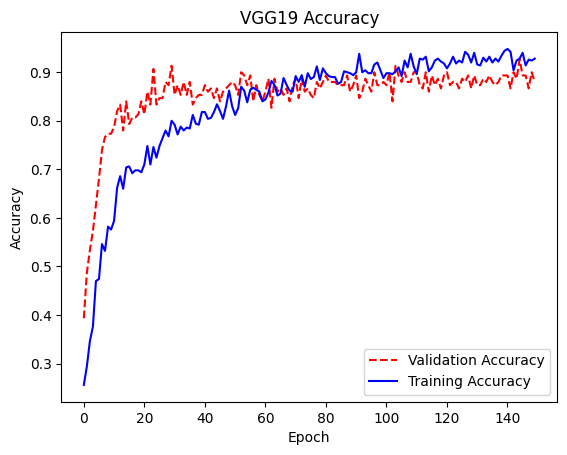

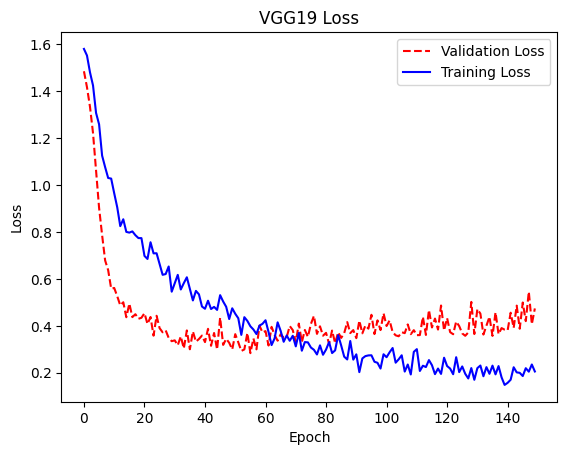

Training ResNet18...
Epoch 1/150
----------
train Loss: 1.7998 Acc: 0.2060
val Loss: 1.7851 Acc: 0.2667

Epoch 2/150
----------
train Loss: 1.7210 Acc: 0.2820
val Loss: 1.6741 Acc: 0.2933

Epoch 3/150
----------
train Loss: 1.6684 Acc: 0.2600
val Loss: 1.5755 Acc: 0.3333

Epoch 4/150
----------
train Loss: 1.5835 Acc: 0.3200
val Loss: 1.4939 Acc: 0.4000

Epoch 5/150
----------
train Loss: 1.5050 Acc: 0.3500
val Loss: 1.4142 Acc: 0.4533

Epoch 6/150
----------
train Loss: 1.4477 Acc: 0.3860
val Loss: 1.3397 Acc: 0.4533

Epoch 7/150
----------
train Loss: 1.3830 Acc: 0.4600
val Loss: 1.2676 Acc: 0.5267

Epoch 8/150
----------
train Loss: 1.3345 Acc: 0.4960
val Loss: 1.2113 Acc: 0.5533

Epoch 9/150
----------
train Loss: 1.2992 Acc: 0.4820
val Loss: 1.1513 Acc: 0.5933

Epoch 10/150
----------
train Loss: 1.2352 Acc: 0.5340
val Loss: 1.0995 Acc: 0.6133

Epoch 11/150
----------
train Loss: 1.1922 Acc: 0.5340
val Loss: 1.0523 Acc: 0.6200

Epoch 12/150
----------
train Loss: 1.1707 Acc: 0.530

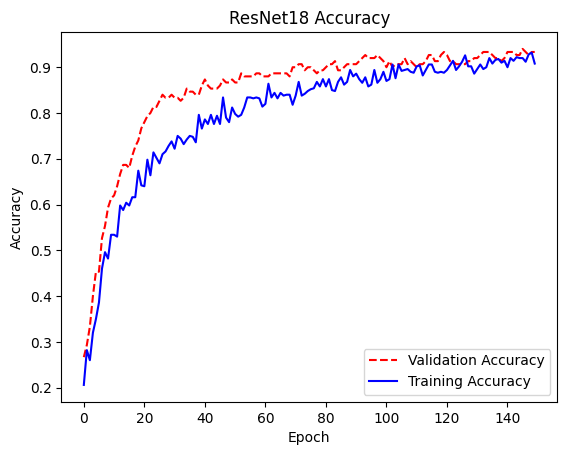

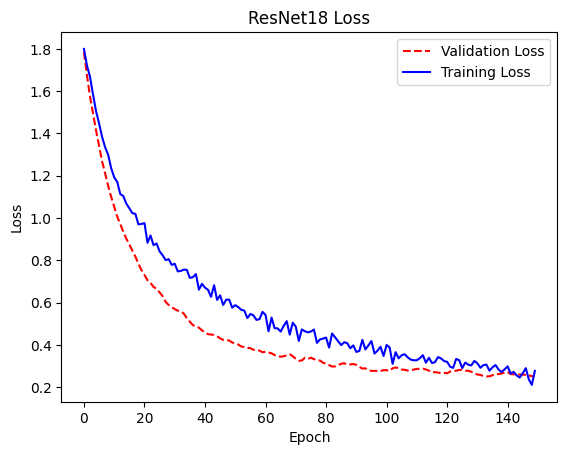

Training ResNet50...
Epoch 1/150
----------
train Loss: 1.6100 Acc: 0.2040
val Loss: 1.5959 Acc: 0.1600

Epoch 2/150
----------
train Loss: 1.5594 Acc: 0.2460
val Loss: 1.5283 Acc: 0.2533

Epoch 3/150
----------
train Loss: 1.4970 Acc: 0.3520
val Loss: 1.4682 Acc: 0.4000

Epoch 4/150
----------
train Loss: 1.4430 Acc: 0.4660
val Loss: 1.4089 Acc: 0.4733

Epoch 5/150
----------
train Loss: 1.4028 Acc: 0.5300
val Loss: 1.3442 Acc: 0.5467

Epoch 6/150
----------
train Loss: 1.3391 Acc: 0.5820
val Loss: 1.2755 Acc: 0.6067

Epoch 7/150
----------
train Loss: 1.2845 Acc: 0.5800
val Loss: 1.1988 Acc: 0.6400

Epoch 8/150
----------
train Loss: 1.2124 Acc: 0.6620
val Loss: 1.1218 Acc: 0.6933

Epoch 9/150
----------
train Loss: 1.1407 Acc: 0.6820
val Loss: 1.0413 Acc: 0.7467

Epoch 10/150
----------
train Loss: 1.1026 Acc: 0.6720
val Loss: 0.9638 Acc: 0.7533

Epoch 11/150
----------
train Loss: 1.0545 Acc: 0.6760
val Loss: 0.8938 Acc: 0.7600

Epoch 12/150
----------
train Loss: 0.9839 Acc: 0.704

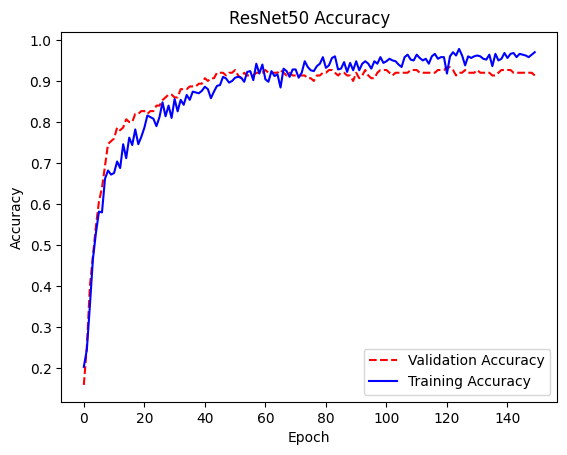

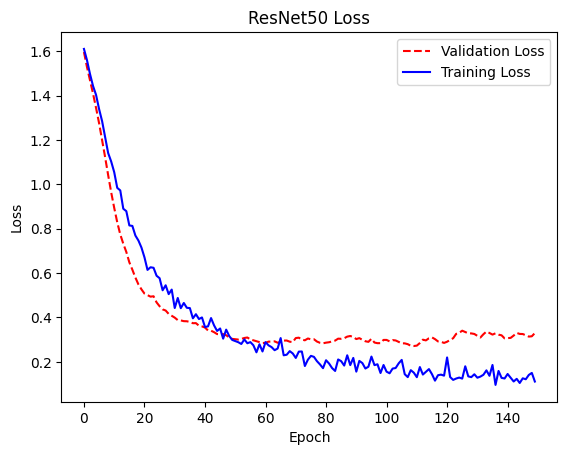

Training Inception_v3...
Epoch 1/150
----------


/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 2.3391 Acc: 0.1800
val Loss: 1.6469 Acc: 0.1800

Epoch 2/150
----------
train Loss: 2.2637 Acc: 0.2240
val Loss: 1.5827 Acc: 0.2600

Epoch 3/150
----------
train Loss: 2.1987 Acc: 0.2680
val Loss: 1.5492 Acc: 0.3200

Epoch 4/150
----------
train Loss: 2.1836 Acc: 0.3080
val Loss: 1.5366 Acc: 0.3800

Epoch 5/150
----------
train Loss: 2.1317 Acc: 0.3040
val Loss: 1.5107 Acc: 0.3933

Epoch 6/150
----------
train Loss: 2.0890 Acc: 0.3900
val Loss: 1.4813 Acc: 0.4267

Epoch 7/150
----------
train Loss: 2.0464 Acc: 0.3940
val Loss: 1.4454 Acc: 0.4467

Epoch 8/150
----------
train Loss: 1.9837 Acc: 0.4700
val Loss: 1.4111 Acc: 0.4933

Epoch 9/150
----------
train Loss: 1.9419 Acc: 0.4820
val Loss: 1.3783 Acc: 0.5333

Epoch 10/150
----------
train Loss: 1.8924 Acc: 0.5180
val Loss: 1.3418 Acc: 0.5533

Epoch 11/150
----------
train Loss: 1.8608 Acc: 0.5120
val Loss: 1.3005 Acc: 0.5800

Epoch 12/150
----------
train Loss: 1.8079 Acc: 0.5460
val Loss: 1.2562 Acc: 0.6000

Epoch 13/150

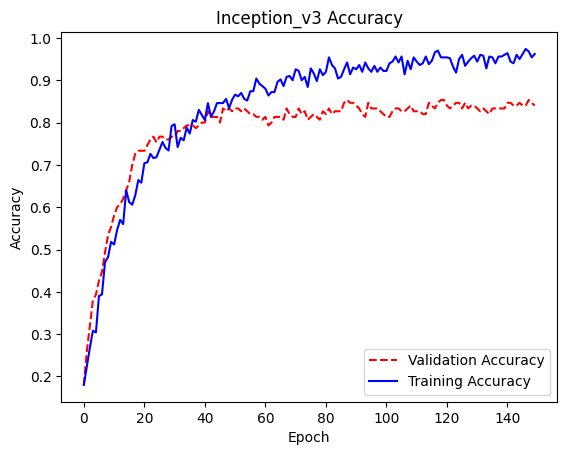

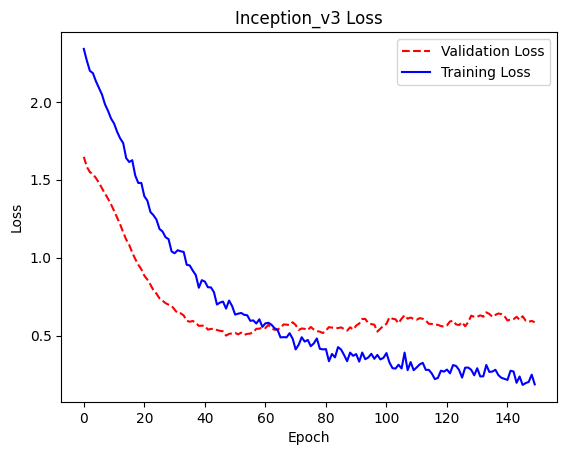

In [23]:
# Loop through each model for training
for model_name, model in models_dict.items():
    
    if loaded or (not loaded and load_checkpoint):
        break

    print(f"Training {model_name}...")

    model = model.to(device)

    # Define Criterion
    criterion = nn.CrossEntropyLoss()

    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # Inception_v3
    is_inception = (model_name == "Inception_v3")

    trained_model, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=150, is_inception=is_inception)

    # Visualize Training Result
    visualize_training(model_name, val_acc_history, val_loss_history, train_acc_history, train_loss_history)

    # Save Checkpoints
    torch.save(trained_model.state_dict(), f"./model/{model_name}_model.pth")

## 2.5 Evaluate Models

Define evalutate function

In [24]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluate mode
    
    all_preds = []
    all_labels = []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, conf_matrix

Start evaluating

Evaluating VGG16...
Accuracy of VGG16: 0.8760


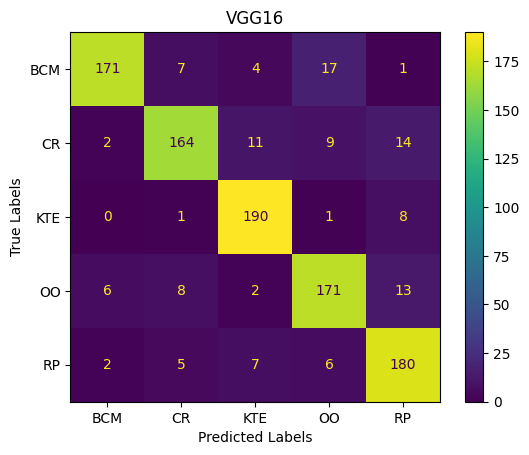

Evaluating VGG19...
Accuracy of VGG19: 0.8760


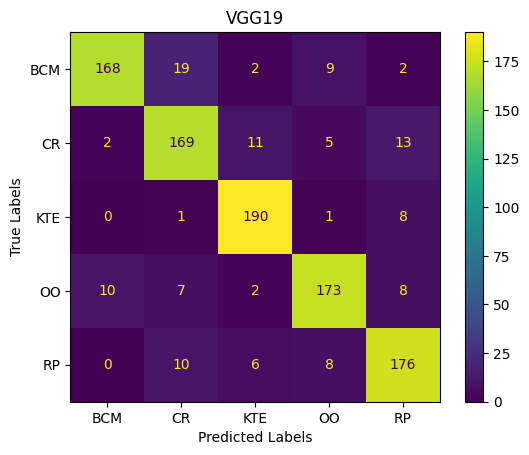

Evaluating ResNet18...
Accuracy of ResNet18: 0.8600


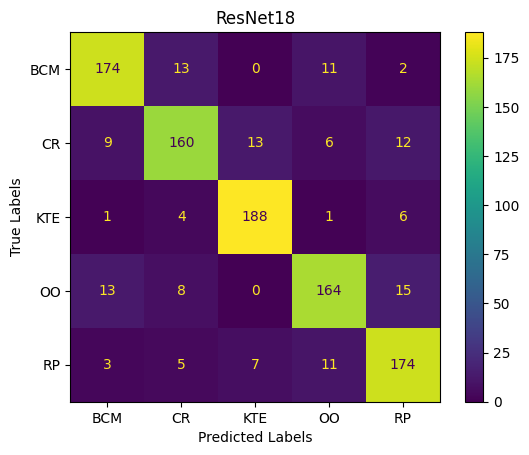

Evaluating ResNet50...
Accuracy of ResNet50: 0.8790


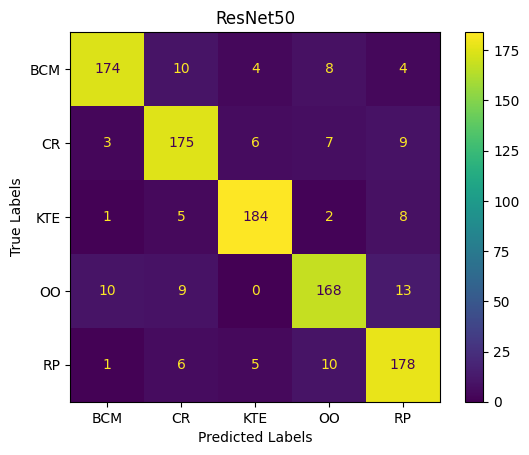

Evaluating Inception_v3...
Accuracy of Inception_v3: 0.8040


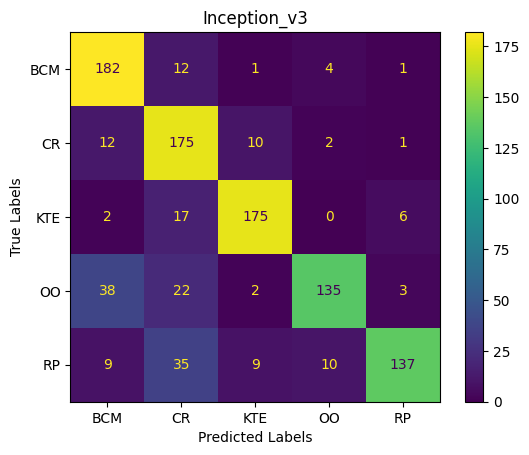

In [25]:
# Loop through each model for evaluation
for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    # Load Checkpoints
    if load_checkpoint and not loaded:
        loaded = True
        model.load_state_dict(torch.load(f"./model/{model_name}_model.pth"))
        model.to(device)
    
    accuracy, conf_matrix = evaluate_model(model, dataloaders['test'])
    print(f"Accuracy of {model_name}: {accuracy:.4f}")

    # Visualize Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["BCM","CR","KTE","OO","RP"])
    disp.plot()
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f'{model_name}')
    plt.show()

# 3. Advanced Part

### 3.1 Binary Classification

**Threshold**

In [26]:
# 检查点加载与模型修改
def load_model(model, model_name, load_checkpoint=True):
    
    if load_checkpoint and not loaded:
        loaded = True
        checkpoint_path = f'./model/{model_name}_model.pth'
        model.load_state_dict(torch.load(checkpoint_path))
        model.to(device)

    return model

Define threshold predict function

In [27]:
def threshold_predict(model, dataloader, threshold=0.5):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # 确保输入数据在正确的设备上
            labels = labels.to(device)  # 确保标签也在正确的设备上
            outputs = model(inputs)
            # 使用softmax来获取概率
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            # 将置信度低于阈值的预测类别设置为5（'others'）
            preds[max_probs < threshold] = 5
            # 在转换前将preds和labels移至CPU
            predictions.extend(preds.cpu().numpy())
            truths.extend(labels.cpu().numpy())
    return predictions, truths


Define evaluate funtion

In [28]:
# 性能评估与可视化
def evaluate_and_visualize(model_name, model, test_loader):
    predictions, truths = threshold_predict(model, test_loader)
    acc = accuracy_score(truths, predictions)
    conf_matrix = confusion_matrix(truths, predictions, labels=[0, 1, 2, 3, 4, 5])
    
    print(f'Accuracy for {model_name}: {acc}')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["BCM","CR","KTE","OO","RP","Others"])
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True') 
    plt.show()

Evaluation

Accuracy for VGG16: 0.3933333333333333


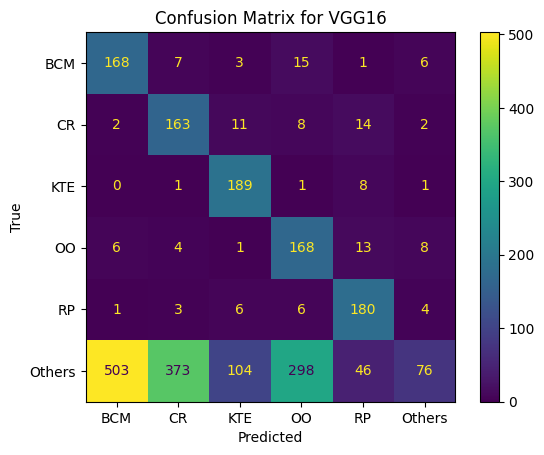

Accuracy for VGG19: 0.38


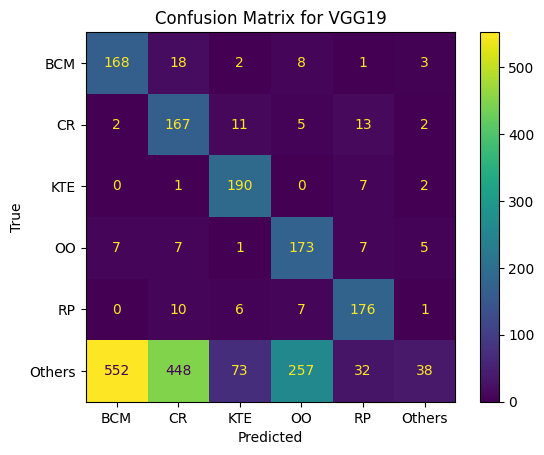

Accuracy for ResNet18: 0.44625


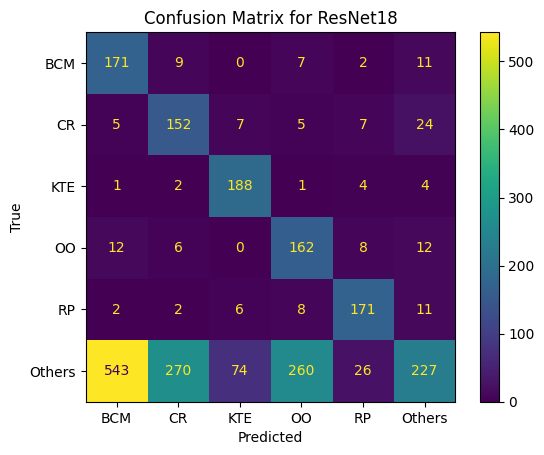

Accuracy for ResNet50: 0.44625


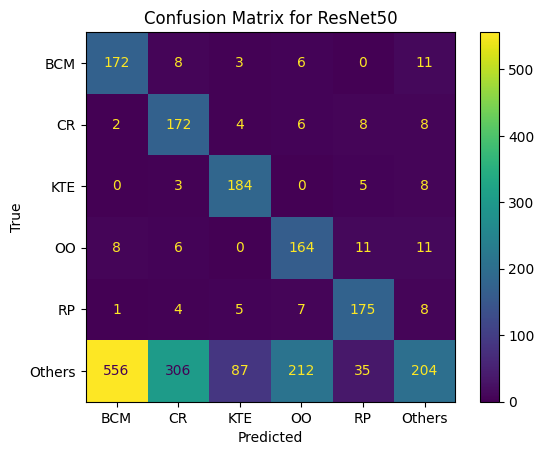

Accuracy for Inception_v3: 0.37958333333333333


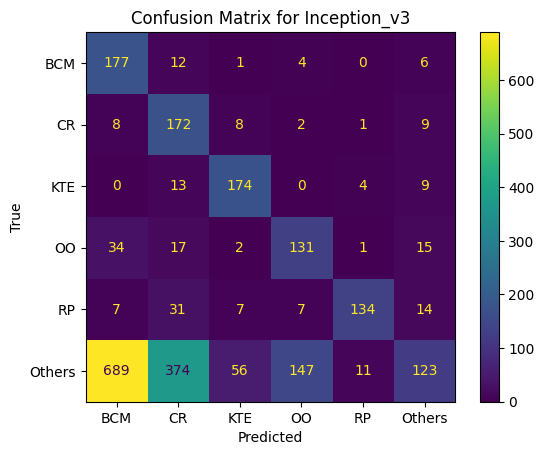

In [29]:
# 主执行逻辑
for name, model in models_dict.items():
    loaded_model = load_model(model, name, load_checkpoint=load_checkpoint)
    evaluate_and_visualize(name, loaded_model, binaryloaders['test'])

**Support Vector Machine (SVM)**

Extract feature use model

In [30]:
def get_features_and_labels(model,dataloader):
    model.eval()
    features = []
    labels = []
    for inputs, label in dataloader:
        inputs = inputs.to(device)
        label = label.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        features.extend(outputs.detach().cpu().numpy())
        labels.extend(label.detach().cpu().numpy())
    
    return features, labels

In [31]:
weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.142}  # 假设类5是“others”类

Extracting features from VGG16...
Model Loaded
Train Features and Labels Extracted
Test Features and Labels Extracted
Pipeline Created
Grid Search Created
Model Fitted
Best parameters of VGG16: {'svc__C': 0.1}
Best cross-validation score of VGG16: 0.59
Test accuracy of VGG16: 0.5100
                    precision    recall  f1-score   support

      Bak Chor Mee       0.29      0.73      0.42       200
      Chicken Rice       0.32      0.81      0.46       200
Kaya Toast and Egg       0.62      0.94      0.75       200
   Oyster Omelette       0.42      0.76      0.54       200
        Roti Prata       0.68      0.84      0.75       200
            Others       0.83      0.29      0.43      1400

          accuracy                           0.51      2400
         macro avg       0.53      0.73      0.56      2400
      weighted avg       0.68      0.51      0.50      2400



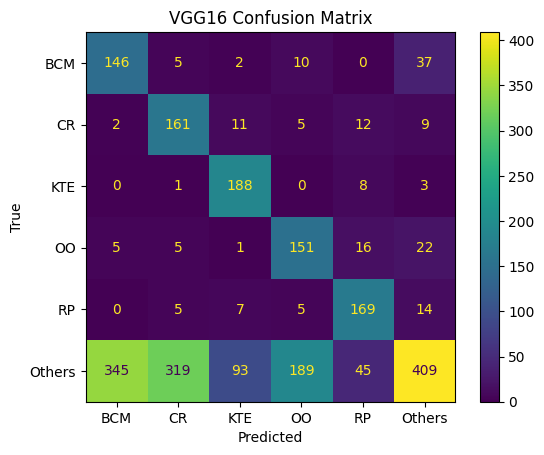

Extracting features from VGG19...
Model Loaded
Train Features and Labels Extracted
Test Features and Labels Extracted
Pipeline Created
Grid Search Created
Model Fitted
Best parameters of VGG19: {'svc__C': 1}
Best cross-validation score of VGG19: 0.60
Test accuracy of VGG19: 0.5179
                    precision    recall  f1-score   support

      Bak Chor Mee       0.27      0.71      0.39       200
      Chicken Rice       0.32      0.82      0.46       200
Kaya Toast and Egg       0.67      0.96      0.79       200
   Oyster Omelette       0.47      0.83      0.60       200
        Roti Prata       0.83      0.82      0.82       200
            Others       0.81      0.29      0.43      1400

          accuracy                           0.52      2400
         macro avg       0.56      0.74      0.58      2400
      weighted avg       0.68      0.52      0.51      2400



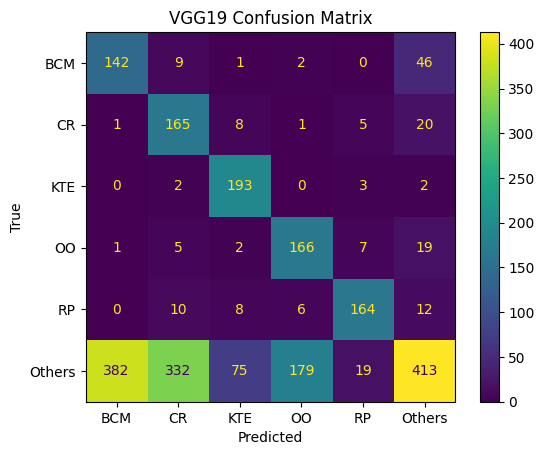

Extracting features from ResNet18...
Model Loaded
Train Features and Labels Extracted
Test Features and Labels Extracted
Pipeline Created
Grid Search Created
Model Fitted
Best parameters of ResNet18: {'svc__C': 0.1}
Best cross-validation score of ResNet18: 0.61
Test accuracy of ResNet18: 0.5554
                    precision    recall  f1-score   support

      Bak Chor Mee       0.28      0.67      0.39       200
      Chicken Rice       0.37      0.79      0.50       200
Kaya Toast and Egg       0.72      0.94      0.81       200
   Oyster Omelette       0.44      0.78      0.56       200
        Roti Prata       0.74      0.86      0.79       200
            Others       0.83      0.38      0.52      1400

          accuracy                           0.56      2400
         macro avg       0.56      0.73      0.60      2400
      weighted avg       0.70      0.56      0.56      2400



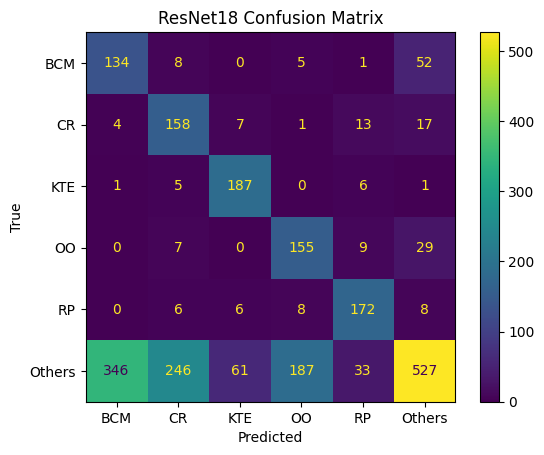

Extracting features from ResNet50...
Model Loaded
Train Features and Labels Extracted
Test Features and Labels Extracted
Pipeline Created
Grid Search Created
Model Fitted
Best parameters of ResNet50: {'svc__C': 0.1}
Best cross-validation score of ResNet50: 0.64
Test accuracy of ResNet50: 0.6154
                    precision    recall  f1-score   support

      Bak Chor Mee       0.27      0.69      0.39       200
      Chicken Rice       0.45      0.82      0.58       200
Kaya Toast and Egg       0.71      0.91      0.80       200
   Oyster Omelette       0.59      0.78      0.67       200
        Roti Prata       0.81      0.87      0.84       200
            Others       0.83      0.47      0.60      1400

          accuracy                           0.62      2400
         macro avg       0.61      0.76      0.65      2400
      weighted avg       0.72      0.62      0.63      2400



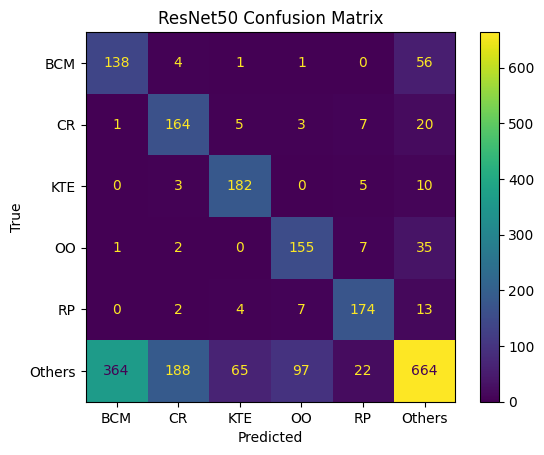

In [32]:
for model_name, model in models_dict.items():

    if model_name == 'Inception_v3':
        continue

    print(f"Extracting features from {model_name}...")
    
    # Load Checkpoints
    if load_checkpoint and not loaded:
        loaded = True
        model.load_state_dict(torch.load(f"./model/{model_name}_model.pth"), strict=False)
        if model_name == 'VGG16':
            model.classifier[6] = nn.Identity()
        elif model_name == 'VGG19':
            model.classifier[6] = nn.Identity()
        elif model_name == 'ResNet18':
            model.fc = nn.Identity()
        elif model_name == 'ResNet50':
            model.fc = nn.Identity()

        model.to(device)
    
    print('Model Loaded')

    # Get features and labels
    train_features, train_labels = get_features_and_labels(model, binaryloaders['train'])
    print('Train Features and Labels Extracted')
    test_features, test_labels = get_features_and_labels(model, binaryloaders['test'])
    print('Test Features and Labels Extracted')
        
    # Train SVM
    pipeline = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', probability=True, class_weight=weights))
    print('Pipeline Created')
    
    # Define param grid
    param_grid = {'svc__C': [0.01, 0.1, 1]}

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    print('Grid Search Created')

    # Fit the model
    grid_search.fit(train_features, train_labels)
    print('Model Fitted')

    # 打印最佳参数和对应的性能评分
    print(f"Best parameters of {model_name}:", grid_search.best_params_)
    print(f"Best cross-validation score of {model_name}: {grid_search.best_score_:.2f}")

    # Evaluate the model
    test_preds = grid_search.predict(test_features)
    test_accuracy = accuracy_score(test_preds, test_labels)
    print(f"Test accuracy of {model_name}: {test_accuracy:.4f}")

    # Print classification report
    print(classification_report(test_labels, test_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BCM","CR","KTE","OO","RP","Others"])
    disp.plot()
    plt.xlabel('Predicted')
    plt.ylabel('True') 
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

### 3.2 Vision Transformer

In [33]:
# 加载预训练的 ViT 模型
configuration = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=configuration)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# 修改分类器头以适应5个类别
ViT_model.classifier = nn.Linear(ViT_model.config.hidden_size, n_classes)

In [35]:
ViT_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [36]:
def ViT_train_model(model, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset)).cpu().numpy()  # 转移到 CPU 并转换为 NumPy

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)  # 保存为 NumPy 数组

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return history


Epoch 1/25
----------
train Loss: 1.5600 Acc: 0.3440
val Loss: 1.4196 Acc: 0.6667
Epoch 2/25
----------
train Loss: 1.3386 Acc: 0.6440
val Loss: 1.1158 Acc: 0.7600
Epoch 3/25
----------
train Loss: 1.0681 Acc: 0.7440
val Loss: 0.7906 Acc: 0.9267
Epoch 4/25
----------
train Loss: 0.8403 Acc: 0.7760
val Loss: 0.6090 Acc: 0.8867
Epoch 5/25
----------
train Loss: 0.6982 Acc: 0.8060
val Loss: 0.4273 Acc: 0.9600
Epoch 6/25
----------
train Loss: 0.5517 Acc: 0.8660
val Loss: 0.3583 Acc: 0.9467
Epoch 7/25
----------
train Loss: 0.4730 Acc: 0.8760
val Loss: 0.2762 Acc: 0.9600
Epoch 8/25
----------
train Loss: 0.3911 Acc: 0.8960
val Loss: 0.2407 Acc: 0.9533
Epoch 9/25
----------
train Loss: 0.3641 Acc: 0.9100
val Loss: 0.2329 Acc: 0.9600
Epoch 10/25
----------
train Loss: 0.3512 Acc: 0.9060
val Loss: 0.2971 Acc: 0.8933
Epoch 11/25
----------
train Loss: 0.3449 Acc: 0.9040
val Loss: 0.2225 Acc: 0.9333
Epoch 12/25
----------
train Loss: 0.3212 Acc: 0.9040
val Loss: 0.2158 Acc: 0.9600
Epoch 13/25
-

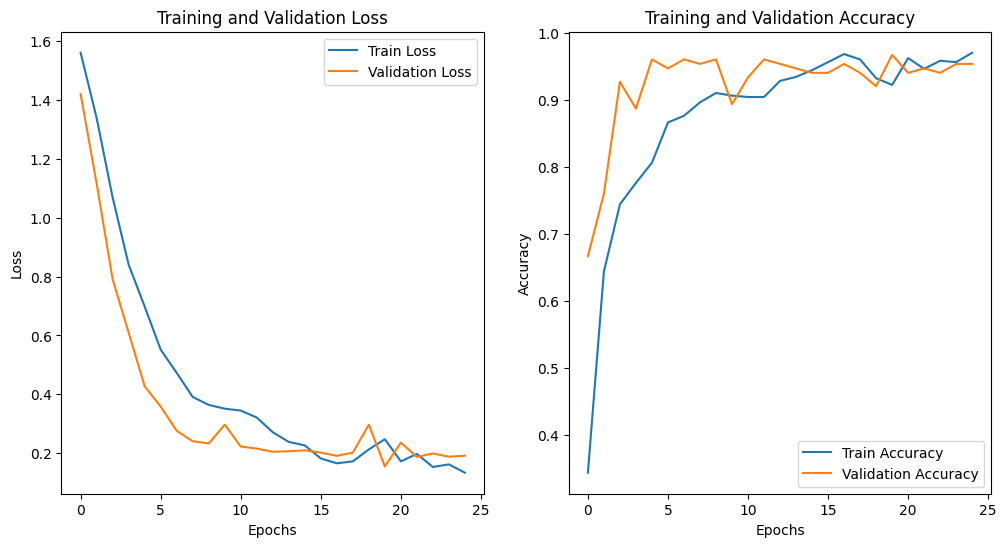

In [37]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ViT_model.parameters(), lr=0.0001)

# 运行训练函数并保存历史记录
history = ViT_train_model(ViT_model, criterion, optimizer, num_epochs=25)
torch.save(ViT_model.state_dict(), './model/ViT_model.pth')

# 绘制训练和验证的损失和准确率
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
torch.save(ViT_model.state_dict(), './model/ViT_model.pth')

evaluate ViT

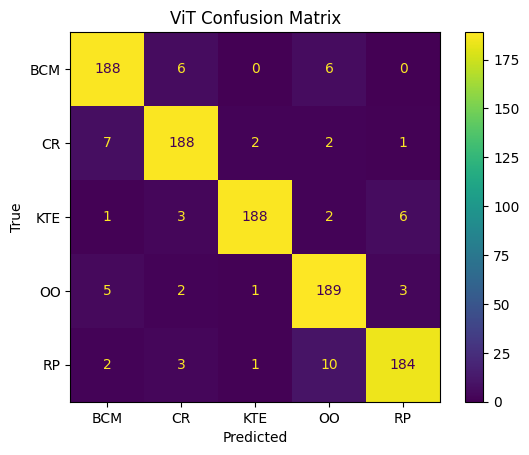

In [39]:
def evaluate_ViT(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# 使用测试数据集评估模型
all_labels, all_preds = evaluate_ViT(ViT_model, dataloaders['test'], device)

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 使用 ConfusionMatrixDisplay 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BCM","CR","KTE","OO","RP"])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True') 
plt.title('ViT Confusion Matrix')
plt.show()

In [40]:
import random

def display_random_images(model, test_loader, class_names, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.logits, 1)  # Get the predicted classes
            
            # Randomly select few images to display
            indices = [i for i in range(len(images)) if random.random() < 5 / len(test_loader.dataset)]
            
            for i in indices:
                image = images[i].permute(1, 2, 0).cpu().numpy()  # Rearrange dimensions to display image properly
                true_label = class_names[labels[i].item()]
                pred_label = class_names[predicted[i].item()]

                plt.figure(figsize=(5, 5))  # Set the figure size
                plt.imshow(image)
                plt.title(f'True: {true_label}, Predicted: {pred_label}')
                plt.axis('off')  # Turn off the axis
                plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


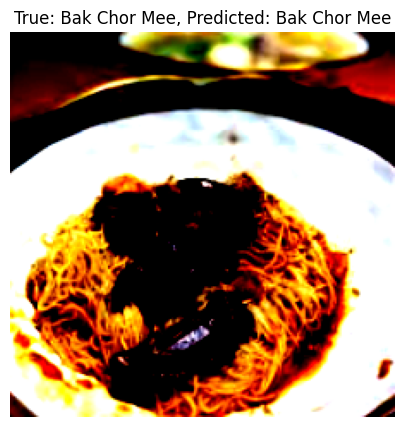

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


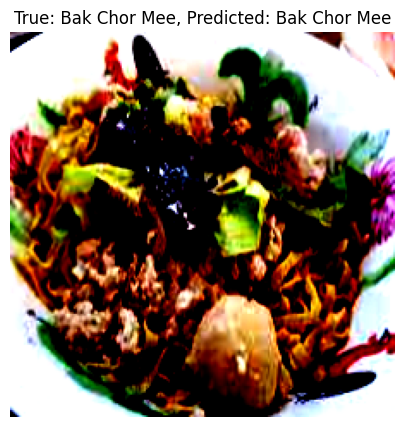

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


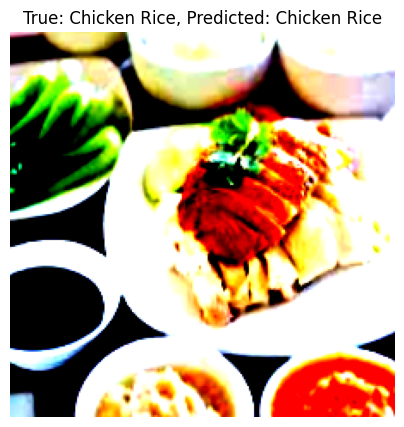

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


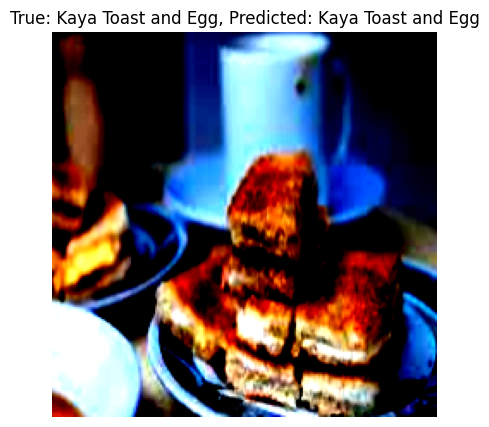

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


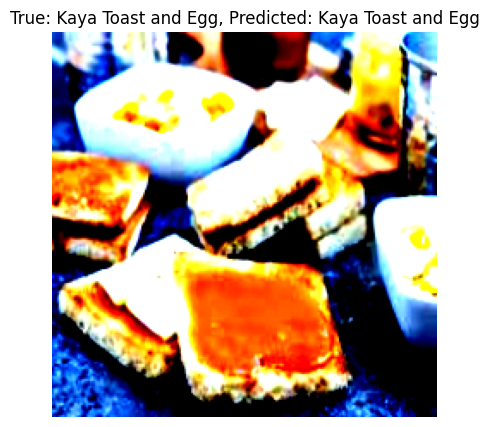

In [41]:
display_random_images(ViT_model, dataloaders['test'], ["Bak Chor Mee", "Chicken Rice", "Kaya Toast and Egg", "Oyster Omelette", "Roti Prata"], device = device)

In [42]:
del ViT_model
torch.cuda.empty_cache()


### 3.3 Swin Transformer (tiny) with lr Scheduler

In [43]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /media/mldadmin/home/s123mdg34_04/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/media/mldadmin/home/s123mdg34_04/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [44]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.head)
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
model = model.to(device)
print(model.head)

Linear(in_features=768, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)


In [45]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

Epoch 1/150
----------
train Loss: 1.4717 Acc: 0.3740
val Loss: 1.2235 Acc: 0.5067

Epoch 2/150
----------
train Loss: 1.1299 Acc: 0.6680
val Loss: 0.8359 Acc: 0.8867

Epoch 3/150
----------
train Loss: 1.0078 Acc: 0.6940
val Loss: 0.7342 Acc: 0.8800

Epoch 4/150
----------
train Loss: 0.9217 Acc: 0.7360
val Loss: 0.7212 Acc: 0.8600

Epoch 5/150
----------
train Loss: 0.9314 Acc: 0.7200
val Loss: 0.6793 Acc: 0.9000

Epoch 6/150
----------
train Loss: 0.8884 Acc: 0.7600
val Loss: 0.6829 Acc: 0.8667

Epoch 7/150
----------
train Loss: 0.9037 Acc: 0.7400
val Loss: 0.6629 Acc: 0.8933

Epoch 8/150
----------
train Loss: 0.8717 Acc: 0.7820
val Loss: 0.6742 Acc: 0.8933

Epoch 9/150
----------
train Loss: 0.8240 Acc: 0.7780
val Loss: 0.6510 Acc: 0.9067

Epoch 10/150
----------
train Loss: 0.8668 Acc: 0.7500
val Loss: 0.6577 Acc: 0.9067

Epoch 11/150
----------
train Loss: 0.7651 Acc: 0.8560
val Loss: 0.6538 Acc: 0.9000

Epoch 12/150
----------
train Loss: 0.8075 Acc: 0.8020
val Loss: 0.6561 Ac

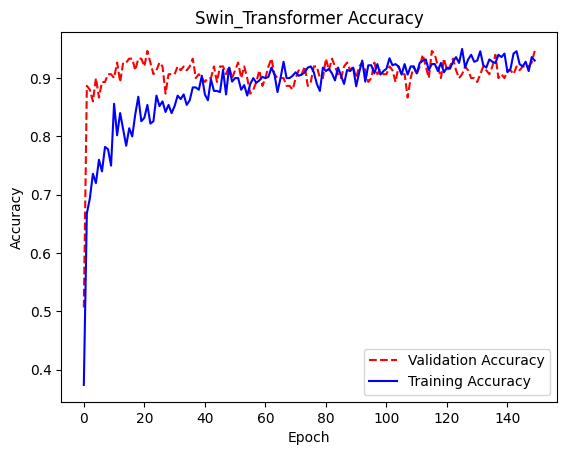

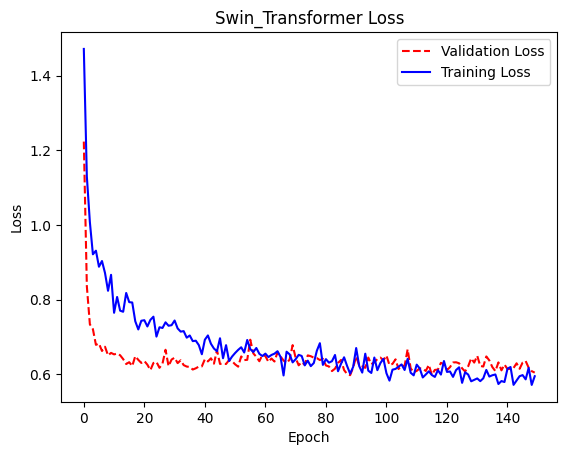

In [46]:
trained_model, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=150, is_inception=False)

model_name = 'Swin_Transformer'
# Visualize Training Result
visualize_training(model_name, val_acc_history, val_loss_history, train_acc_history, train_loss_history)

# Save Checkpoints
torch.save(trained_model.state_dict(), f"./model/{model_name}_model.pth")


evaluate Swin Transformer

Accuracy of Swin_Transformer: 0.8760


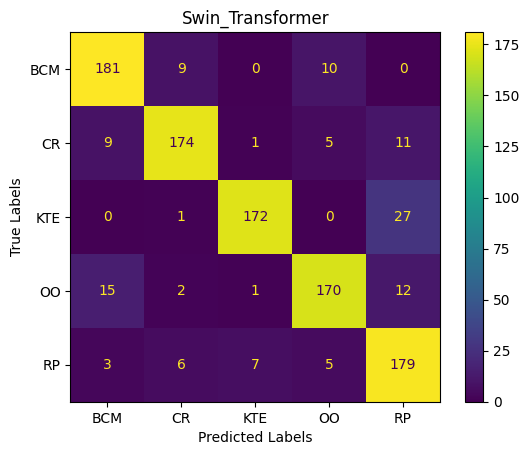

In [47]:
accuracy, conf_matrix = evaluate_model(model, dataloaders['test'])
print(f"Accuracy of {model_name}: {accuracy:.4f}")

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["BCM","CR","KTE","OO","RP"])
disp.plot()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f'{model_name}')
plt.show()

In [48]:
del model
torch.cuda.empty_cache()

### 3.4 Ensemble Learning

In [49]:
def evaluate_ensemble(model_dict, test_dataloader, class_names, aggregation_type, load_checkpoint, device):
    for model_name, model in model_dict.items():
        if load_checkpoint:
            model.load_state_dict(torch.load(f"./model/{model_name}_model.pth"))
        model.to(device).eval()
    
    total_preds = []
    total_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            ensemble_outputs = []

            for model in model_dict.values():
                outputs = model(images)
                if aggregation_type == 'voting':
                    _, preds = torch.max(outputs, 1)
                    ensemble_outputs.append(preds.cpu().numpy())
                elif aggregation_type == 'averaging':
                    ensemble_outputs.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

            ensemble_outputs = np.array(ensemble_outputs)
            if aggregation_type == 'voting':
                final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, ensemble_outputs)
            elif aggregation_type == 'averaging':
                final_preds = np.argmax(np.mean(ensemble_outputs, axis=0), axis=1)

            total_preds.extend(final_preds)
            total_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(total_labels, total_preds)
    cm = confusion_matrix(total_labels, total_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 10))
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {aggregation_type.capitalize()}')
    plt.show()

    return acc

Ensemble learning with voting


<Figure size 1000x1000 with 0 Axes>

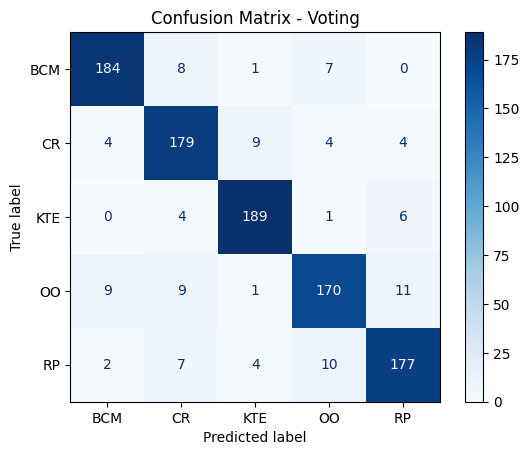

Accuracy: 89.90%
Ensemble learning with averaging


<Figure size 1000x1000 with 0 Axes>

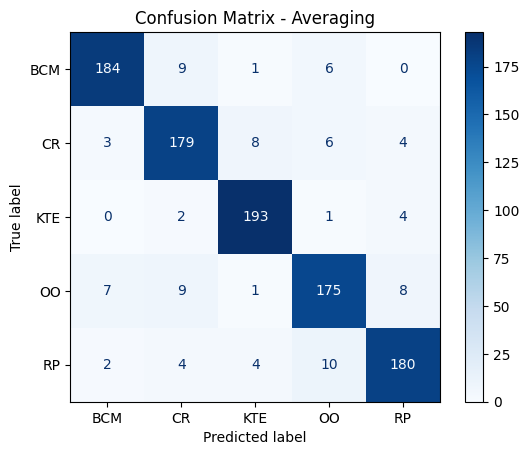

Accuracy: 91.10%


In [50]:
# Use the function
test_loader = dataloaders['test']
class_names = ["BCM","CR","KTE","OO","RP"]
aggregation_types = ['voting', 'averaging']

for agg_type in aggregation_types:
    print(f"Ensemble learning with {agg_type}")
    acc = evaluate_ensemble(models_dict, test_loader, class_names, agg_type, load_checkpoint, device)
    print(f"Accuracy: {100*acc:.2f}%")


Clean cache

In [51]:
for _, model in models_dict.items():
    del model
torch.cuda.empty_cache()

### 3.5 Fast Computation

Initialize models for fast computation

In [61]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights

In [62]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify VGG19
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Resnet50
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

In [63]:
vgg16 = torch.compile(vgg16, mode='max-autotune')
vgg19 = torch.compile(vgg19, mode='max-autotune')
resnet18 = torch.compile(resnet18, mode='max-autotune')
resnet50 = torch.compile(resnet50, mode='max-autotune')
inception_v3 = torch.compile(inception_v3, mode='max-autotune')

Use torch.compile to speed up the train

In [64]:
fast_models_dict = {
    "VGG16": vgg16,
    "VGG19": vgg19,
    "ResNet18": resnet18,
    "ResNet50": resnet50,
    "Inception_v3": inception_v3
}

In [88]:
del vgg16
torch.cuda.empty_cache()

In [65]:
# Loop through each model for training
for model_name, model in fast_models_dict.items():
    
    if loaded or (not loaded and load_checkpoint):
        break

    print(f"Training {model_name}...")

    model = model.to(device)

    # Define Criterion
    criterion = nn.CrossEntropyLoss()

    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # Inception_v3
    is_inception = (model_name == "Inception_v3")

    trained_model, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=150, is_inception=is_inception)

    # Visualize Training Result
    visualize_training(model_name, val_acc_history, val_loss_history, train_acc_history, train_loss_history)

    # Save Checkpoints
    torch.save(trained_model.state_dict(), f"./model/{model_name}_model.pth")

Training VGG16...
Epoch 1/150
----------


BackendCompilerFailed: backend='inductor' raised:
LoweringException: ValueError: Pointer argument (at 0) cannot be accessed from Triton (cpu tensor?)
  target: aten.convolution.default
  args[0]: TensorBox(StorageBox(
    ComputedBuffer(name='buf13', layout=FixedLayout('cuda', torch.float32, size=[64, 3, 224, 224], stride=[150528, 1, 672, 3]), data=Pointwise(
      'cuda',
      torch.float32,
      def inner_fn(index):
          i0, i1, i2, i3 = index
          tmp0 = ops.load(primals_33, i3 + 224 * i2 + 50176 * i1 + 150528 * i0)
          return tmp0
      ,
      ranges=[64, 3, 224, 224],
      origin_node=primals_33,
      origins={primals_33}
    ))
  ))
  args[1]: TensorBox(StorageBox(
    ComputedBuffer(name='buf0', layout=FixedLayout('cuda', torch.float32, size=[64, 3, 3, 3], stride=[27, 1, 9, 3]), data=Pointwise(
      'cuda',
      torch.float32,
      def inner_fn(index):
          i0, i1, i2, i3 = index
          tmp0 = ops.load(primals_1, i3 + 3 * i2 + 9 * i1 + 27 * i0)
          return tmp0
      ,
      ranges=[64, 3, 3, 3],
      origin_node=primals_1,
      origins={primals_1}
    ))
  ))
  args[2]: TensorBox(StorageBox(
    InputBuffer(name='primals_2', layout=FixedLayout('cuda', torch.float32, size=[64], stride=[1]))
  ))
  args[3]: [1, 1]
  args[4]: [1, 1]
  args[5]: [1, 1]
  args[6]: False
  args[7]: [0, 0]
  args[8]: 1

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


Clean cache

In [66]:
for _, model in fast_models_dict.items():
    del model
torch.cuda.empty_cache()

### 3.6 Knowledge Distillation

Define Teacher Vision Transformer

In [67]:
# 加载预训练的 ViT 模型
configuration = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=configuration)
ViT_model.classifier = nn.Linear(ViT_model.config.hidden_size, 5)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialize teacher and student

In [68]:
# Instantiate the Vision Transformer model as the teacher model
teacher_model = ViT_model.to(device)

trained_state_dict = torch.load('./model/ViT_model.pth', map_location=device)
teacher_model.load_state_dict(trained_state_dict)
teacher_model.eval()
teacher_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [69]:
# Instantiate the student model
student_type = "Resnet18"
student_model = models.resnet18(pretrained=True)

# change the final layer of ResNet Model for Transfer Learning
fc_inputs = student_model.fc.in_features
student_model.fc = nn.Sequential(nn.Linear(fc_inputs, 5)) # change no. of classes
student_model = student_model.to(device)

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Preparation

In [70]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validation_step(model, batch, temperature):
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)
    teacher_pred = teacher_model(images)                  # Generate predictions
    out = model(images) 
    loss = 0.5*(distillation_loss(out, teacher_pred, temperature)) + 0.5*(criterion(out, labels))   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result, temperature):
    print("Epoch [{}], last_lr: {:.8f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    if result['val_acc']>0.93:
        torch.save(student_model.state_dict(), f'{student_type}-student_of_{teacher_type}_{temperature}_acc93.pth')

In [71]:
# Define the distillation loss function
def distillation_loss(student_outputs, teacher_outputs, temperature):
    # 首先提取 logits
    if hasattr(teacher_outputs, 'logits'):
        teacher_logits = teacher_outputs.logits
    else:
        teacher_logits = teacher_outputs  # 备用，以防 logits 不存在

    if hasattr(student_outputs, 'logits'):
        student_logits = student_outputs.logits
    else:
        student_logits = student_outputs  # 备用，以防 logits 不存在

    # 然后应用 softmax 和 log_softmax
    soft_teacher_outputs = torch_f.softmax(teacher_logits / temperature, dim=1)
    soft_student_outputs = torch_f.log_softmax(student_logits / temperature, dim=1)

    # 计算 KL 散度
    return torch_f.kl_div(soft_student_outputs, soft_teacher_outputs, reduction='batchmean')


In [72]:
@torch.no_grad()
def evaluate(model, val_loader, temperature):
    model.eval()
    outputs = [validation_step(model,batch,temperature) for batch in val_loader]
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr,temperature, teacher_model, student_model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, criterion = nn.CrossEntropyLoss()):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(student_model.parameters(), max_lr)#, weight_decay=weight_decay)
                        # optimizer for student
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        teacher_model.eval()
        student_model.train()
        
        cls_losses = []
        div_losses = []
        losses = []
        lrs = []
        for batch in train_loader:
            teacher_model.eval()
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)
            
            teacher_pred = teacher_model(images)                  # Generate predictions
            cls_pred = student_model(images)                  # Generate predictions
            
            
#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(student_model.parameters(), grad_clip)

            cls_loss = criterion(cls_pred, labels) # Calculate loss
            div_loss = distillation_loss(cls_pred, teacher_pred, temperature)
            
            
            cls_losses.append(cls_loss)
            div_losses.append(div_loss)
            
            loss = 0.5 * cls_loss + 0.5 * div_loss
            
            losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(student_model, val_loader, temperature)
        
        result['div_loss'] = torch.stack(div_losses).mean().item()
        result['cls_loss'] = torch.stack(cls_losses).mean().item()
        
        result['train_loss'] = torch.stack(losses).mean().item()
        result['lrs'] = lrs
        
        epoch_end(epoch, result, temperature)
        history.append(result)
    return history

Train

In [73]:
epochs = 20
max_lr = 1e-4
grad_clip = 0
weight_decay = 5e-4
opt_func = torch.optim.Adam
criterion = nn.CrossEntropyLoss()

In [74]:
%%time
temperature = 3 # Temperature parameter for distillation
history = fit_one_cycle(epochs, max_lr,temperature, teacher_model,student_model, dataloaders['train'], dataloaders['val'], 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  5%|▌         | 1/20 [00:07<02:25,  7.67s/it]

Epoch [0], last_lr: 0.00000916, train_loss: 0.9909, val_loss: 1.0473, val_acc: 0.2031


 10%|█         | 2/20 [00:15<02:17,  7.64s/it]

Epoch [1], last_lr: 0.00002617, train_loss: 0.9306, val_loss: 0.9612, val_acc: 0.2604


 15%|█▌        | 3/20 [00:22<02:07,  7.51s/it]

Epoch [2], last_lr: 0.00005040, train_loss: 0.8594, val_loss: 0.8223, val_acc: 0.4659


 20%|██        | 4/20 [00:30<02:00,  7.53s/it]

Epoch [3], last_lr: 0.00007507, train_loss: 0.7362, val_loss: 0.6596, val_acc: 0.6193


 25%|██▌       | 5/20 [00:37<01:53,  7.58s/it]

Epoch [4], last_lr: 0.00009330, train_loss: 0.6158, val_loss: 0.4643, val_acc: 0.6553


 30%|███       | 6/20 [00:45<01:46,  7.60s/it]

Epoch [5], last_lr: 0.00010000, train_loss: 0.5109, val_loss: 0.3596, val_acc: 0.7519


 35%|███▌      | 7/20 [00:52<01:35,  7.36s/it]

Epoch [6], last_lr: 0.00009875, train_loss: 0.4618, val_loss: 0.3550, val_acc: 0.7633


 40%|████      | 8/20 [00:59<01:28,  7.37s/it]

Epoch [7], last_lr: 0.00009505, train_loss: 0.4015, val_loss: 0.2950, val_acc: 0.8253


 45%|████▌     | 9/20 [01:06<01:20,  7.31s/it]

Epoch [8], last_lr: 0.00008909, train_loss: 0.3680, val_loss: 0.2952, val_acc: 0.7992


 50%|█████     | 10/20 [01:13<01:11,  7.19s/it]

Epoch [9], last_lr: 0.00008117, train_loss: 0.3548, val_loss: 0.2519, val_acc: 0.8248


 55%|█████▌    | 11/20 [01:21<01:06,  7.39s/it]

Epoch [10], last_lr: 0.00007169, train_loss: 0.3181, val_loss: 0.2271, val_acc: 0.8613


 60%|██████    | 12/20 [01:29<01:00,  7.58s/it]

Epoch [11], last_lr: 0.00006113, train_loss: 0.2968, val_loss: 0.2788, val_acc: 0.8196


 65%|██████▌   | 13/20 [01:37<00:53,  7.68s/it]

Epoch [12], last_lr: 0.00005000, train_loss: 0.2676, val_loss: 0.3151, val_acc: 0.7779


 70%|███████   | 14/20 [01:45<00:46,  7.74s/it]

Epoch [13], last_lr: 0.00003887, train_loss: 0.2553, val_loss: 0.2605, val_acc: 0.8504


 75%|███████▌  | 15/20 [01:53<00:38,  7.70s/it]

Epoch [14], last_lr: 0.00002831, train_loss: 0.2724, val_loss: 0.2220, val_acc: 0.8821


 80%|████████  | 16/20 [01:59<00:29,  7.36s/it]

Epoch [15], last_lr: 0.00001883, train_loss: 0.2464, val_loss: 0.2138, val_acc: 0.8873


 85%|████████▌ | 17/20 [02:06<00:21,  7.15s/it]

Epoch [16], last_lr: 0.00001091, train_loss: 0.2759, val_loss: 0.2062, val_acc: 0.9025


 90%|█████████ | 18/20 [02:14<00:14,  7.32s/it]

Epoch [17], last_lr: 0.00000495, train_loss: 0.2599, val_loss: 0.2053, val_acc: 0.8920


 95%|█████████▌| 19/20 [02:20<00:07,  7.13s/it]

Epoch [18], last_lr: 0.00000125, train_loss: 0.2907, val_loss: 0.2070, val_acc: 0.8973


100%|██████████| 20/20 [02:28<00:00,  7.44s/it]

Epoch [19], last_lr: 0.00000000, train_loss: 0.2719, val_loss: 0.2060, val_acc: 0.8920
CPU times: user 37min 40s, sys: 56.6 s, total: 38min 36s
Wall time: 2min 28s


In [75]:
torch.save(student_model.state_dict(), f'./model/knowledgeDistillation.pth')

In [76]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

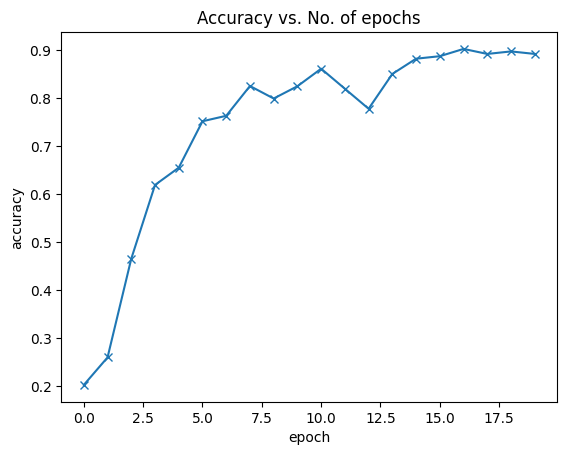

In [77]:
plot_accuracies(history)

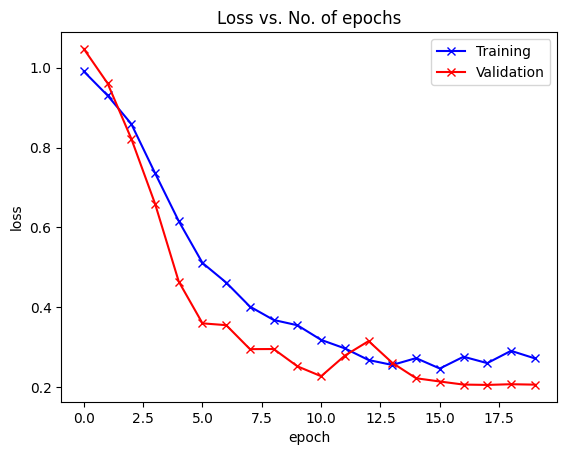

In [78]:
plot_losses(history)

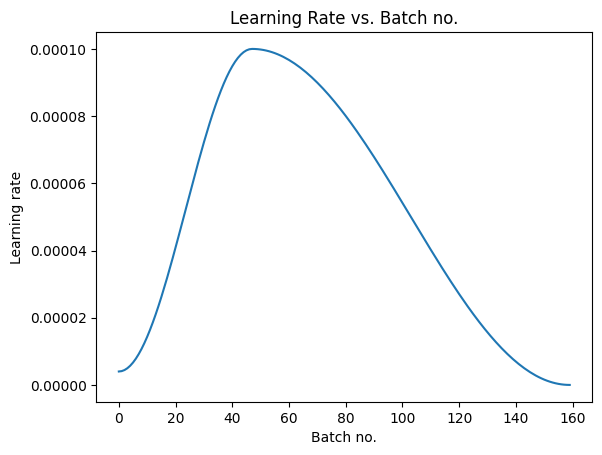

In [79]:
plot_lrs(history)

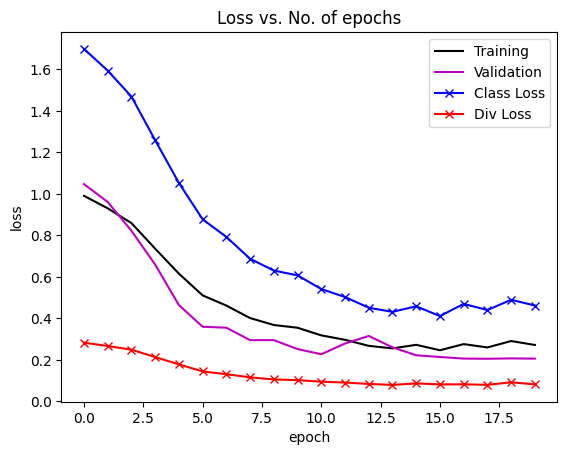

In [80]:
def plot_losses(history):
    cls_losses = [x.get('cls_loss') for x in history]
    div_losses = [x.get('div_loss') for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, 'k')
    plt.plot(val_losses, 'm')
    
    plt.plot(cls_losses, '-bx')
    plt.plot(div_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation', 'Class Loss','Div Loss'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history)

In [81]:
def get_model_results(model, dataloaders):
    accuracy, conf_matrix = evaluate_model(model, dataloaders)
    print(f"Accuracy of Knowledge Distillation: {accuracy:.4f}")

    # Visualize Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["BCM","CR","KTE","OO","RP"])
    disp.plot()
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title('Accuracy of Knowledge Distillation')
    plt.show()

Accuracy of Knowledge Distillation: 0.8620


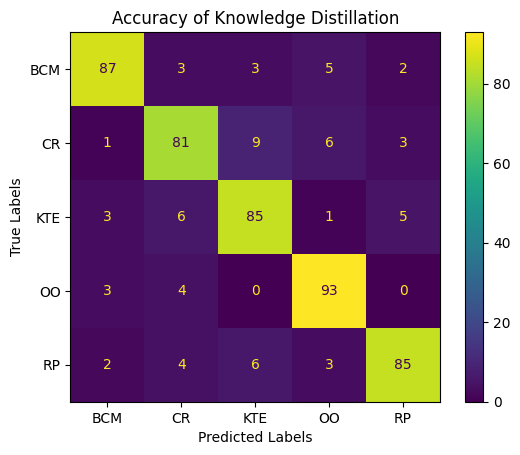

CPU times: user 1min 25s, sys: 1.49 s, total: 1min 27s
Wall time: 5.47 s


In [82]:
%%time
get_model_results(student_model,dataloaders['train'])


Accuracy of Knowledge Distillation: 0.9000


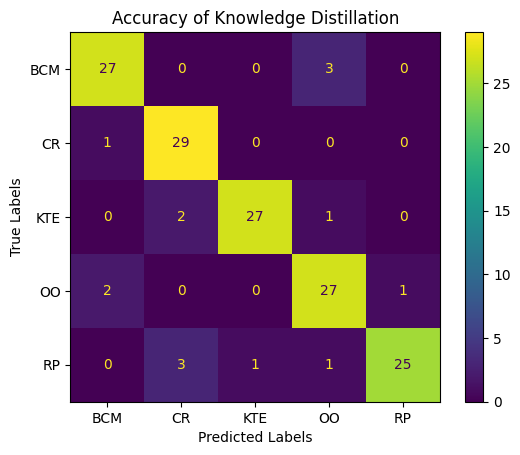

CPU times: user 10.5 s, sys: 180 ms, total: 10.6 s
Wall time: 665 ms


In [83]:
%%time
get_model_results(student_model,dataloaders['val'])


Accuracy of Knowledge Distillation: 0.8570


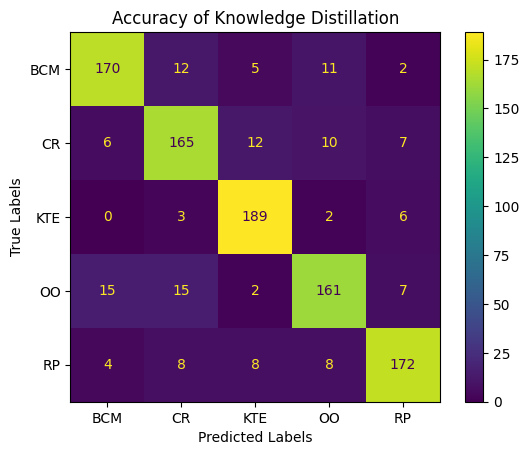

CPU times: user 50 s, sys: 952 ms, total: 50.9 s
Wall time: 3.18 s


In [84]:
%%time
get_model_results(student_model,dataloaders['test'])


Test classifier

In [85]:
# Instantiate the student model
student_type = "Resnet18"
student_model1 = models.resnet18(pretrained=True)

# change the final layer of ResNet Model for Transfer Learning
fc_inputs = student_model1.fc.in_features
student_model1.fc = nn.Sequential(nn.Linear(fc_inputs, 5)) # change no. of classes

student_model1.load_state_dict(torch.load('./model/knowledgeDistillation.pth'))
student_model1 = student_model1.to(device)
student_model1.eval()



/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy of Knowledge Distillation: 0.8570


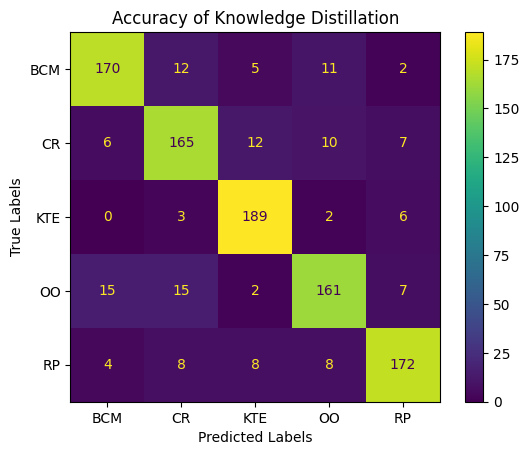

CPU times: user 43.4 s, sys: 999 ms, total: 44.4 s
Wall time: 2.78 s


In [86]:
%%time
get_model_results(student_model1,dataloaders['test'])

In [87]:
del teacher_model
del student_model
del student_model1
torch.cuda.empty_cache()